# Analysis Setup 

In [2]:
from climpred.prediction import compute_perfect_model
from PMMPIESM.predictability import _pseudo_ens_GE
from tqdm import trange
from PMMPIESM.plot import _set_integer_xaxis

import numpy as np
import xarray as xr
import pandas as pd
from esmtools.stats import rm_poly
import matplotlib.pyplot as plt
import PMMPIESM as PM
import seaborn as sb
from PMMPIESM.setup import file_origin, yearmonmean
import seaborn as sb
colors = ["dark blue", "faded blue", "steel blue", "faded green", "faded red"]
cmap=sb.xkcd_palette(colors)
import warnings
warnings.simplefilter("ignore")
from climpred.prediction import compute_perfect_model

In [3]:
#### SAVING FIGURES
## the default savefig params can be different from the display params
## e.g., you may want a higher resolution, or to make the figure
## background white
import matplotlib as mpl
import os
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['legend.fontsize'] = 'small'
#savefig.dpi         : figure   ## figure dots per inch or 'figure'
mpl.rcParams['savefig.dpi'] = 300
#savefig.facecolor   : white    ## figure facecolor when saving
#savefig.edgecolor   : white    ## figure edgecolor when saving
#savefig.format      : png      ## png, ps, pdf, svg
mpl.rcParams['savefig.format'] = 'eps'
#savefig.bbox        : standard ## 'tight' or 'standard'.
                                ## 'tight' is incompatible with pipe-based animation
                                ## backends but will workd with temporary file based ones:
                                ## e.g. setting animation.writer to ffmpeg will not work,
                                ## use ffmpeg_file instead
mpl.rcParams['savefig.bbox'] = 'tight'
#savefig.pad_inches  : 0.1      ## Padding to be used when bbox is set to 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.02
#savefig.jpeg_quality: 95       ## when a jpeg is saved, the default quality parameter.
paper_path = '/Users/aaron.spring/PhD_Thesis/My_Paper/ToE_mitigation_detection/'

In [4]:
sb.set_context('talk')

In [5]:
longname_diag=dict()
longname_diag['co2_flx_land'] = 'diag. atm. CO$_{2}$ due to land'
longname_diag['co2_flx_ocean'] = 'diag. atm. CO$_{2}$ due to ocean'

In [6]:
units=dict()
units['combined']='ppm'
units['ocean']='ppm'
units['land']='ppm'
units['tsurf']='$^\circ$C'
units['co2_flux']='PgC/yr'
units['co2_flx_land']='PgC/yr'
units['co2_flx_ocean']='PgC/yr'

longname=dict()
longname['combined']='diag. CO$_{2,atm}$'
longname['land']='diag. CO$_{2,atm}$ due to land'
longname['ocean']='diag. CO$_{2,atm}$ due to ocean'
longname['tsurf']='GMST'
longname['co2_flux']='CO$_2$ flux'
longname['co2_flx_land']='ocean CO$_2$ flux'
longname['co2_flx_ocean']='land CO$_2$ flux'

In [7]:
sig=95
psig=sig/100
lcil=((100-sig)/2)/100
ucil=1-lcil

In [8]:
data_path = '../data/plain_model_output/'

## Load from file

In [9]:
co2atm_forcing = xr.open_dataset(data_path+'co2atm.nc').drop('member').rename({'ext':'member','year':'time'})
cf=xr.open_dataset(data_path+'GE_co2_flux.nc').rename({'member':'initialization','ext':'member','year':'time'})

In [10]:
c4mip = xr.open_dataset(data_path+'CMIP6_C4MIP_ensemble_CO2_co2_flux.nc')

#### pre-defined functions

In [26]:
from esmtools.stats import linregress
def linear_detrend(cf,end=2005,start=1850,dim='time'):
    if isinstance(cf,xr.Dataset):
        varl=[]
        for var in cf.data_vars:
            detrended = remove_trend(cf[var],end=end,start=start,dim=dim)
            detrended.name = var
            varl.append(detrended)
        cf_detrended = xr.merge(varl)
    else:
        cf_detrended = remove_trend(cf)
    return cf_detrended

def remove_trend(ds,start=1850,end=2005,dim='time'):
    res = linregress(ds.sel(time=slice(start,end))[dim],ds.sel(time=slice(start,end)))
    lfit=res['intercept']+res['slope']*ds.time
    detrended = (ds - lfit + ds.mean('time'))
    return detrended

## Setting the context
### Evolution of Historical and RCPs

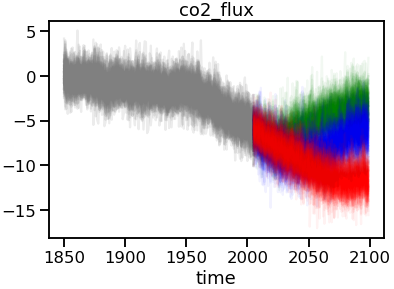

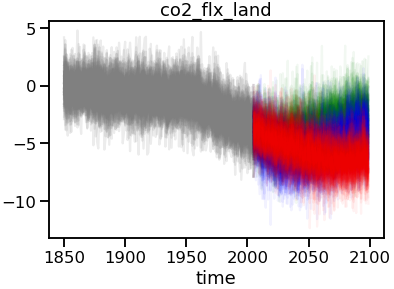

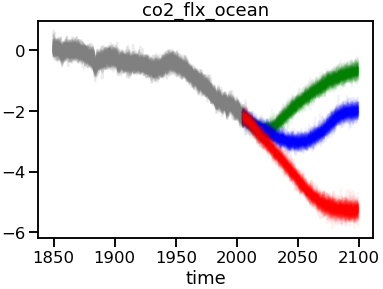

In [27]:
carbon_fluxes=cf.to_dataframe()
cmape=['g','b','r']
all_ext=['rcp26','rcp45','rcp85']
for varname in carbon_fluxes.columns:
    fig, ax = plt.subplots()
    carbon_fluxes[varname].unstack(1)[all_ext[1]].unstack(0).loc[:2005].plot(ax=ax,color='gray',legend=False,alpha=.15)
    for i,ext in enumerate(all_ext):
        carbon_fluxes[varname].unstack(1)[ext].unstack(0).loc[2005:].plot(ax=ax,color=cmape[i],legend=False,alpha=.05)
    ax.set_title(varname)

## prescribed emissions in CMIP5

In [27]:
import pandas as pd

# unsure whether including LUC emission or not
def get_iam_emissions(include_LUC_emissions=True):
    """Download IAM emissions from PIK website.
    Returns:
        iam_emissions (xr.object): emissions from the IAMs in PgC/yr.
    """
    ds = []
    member = ["rcp26", "rcp45", "rcp85"]
    for r in member:
        if r == "rcp26":
            r = "rcp3pd"
        r = r.upper()
        link = f"http://www.pik-potsdam.de/~mmalte/rcps/data/{r}_EMISSIONS.xls"
        e = pd.read_excel(link, sheet_name=f"{r}_EMISSIONS", skiprows=35, header=2)
        e = e.set_index(e.columns[0])
        e.index.name = "Year"
        ds.append(e[["FossilCO2", "OtherCO2"]].to_xarray())
    ds = xr.concat(ds, "member")
    ds = ds.sel(Year=slice(1850, 2100)).rename({"Year": "time"})
    ds["member"] = member
    ds["IAM_emissions"] = ds["FossilCO2"] 
    if include_LUC_emissions:
        ds["IAM_emissions"] += ds["OtherCO2"]
    return ds["IAM_emissions"]

In [28]:
iam_emissions = xr.Dataset()
iam_emissions['fossil_fuel']=get_iam_emissions(include_LUC_emissions=False)
iam_emissions['land_use']=get_iam_emissions(include_LUC_emissions=True)-get_iam_emissions(include_LUC_emissions=False)
iam_emissions['total_anth']=get_iam_emissions(include_LUC_emissions=True)
iam_emissions=iam_emissions.sel(time=slice(2005,2040))

In [29]:
def get_gcb_emissions(include_LUC_emissions):
    gcb_emssions = pd.read_excel('../data/Global_Carbon_Budget_2019v1.0.xlsx',sheet_name='Global Carbon Budget',header=18)
    gcb_emssions['anth_emissions'] = gcb_emssions['fossil fuel and industry']
    if include_LUC_emissions:
        gcb_emssions['anth_emissions'] += gcb_emssions['land-use change emissions']
    gcb_emssions = gcb_emssions[['Year','anth_emissions']].set_index('Year')
    xr_anth_emissions = gcb_emssions.to_xarray().rename({'Year':'time'})['anth_emissions']
    return xr_anth_emissions

In [30]:
gcb_emissions = xr.Dataset()
gcb_emissions['fossil_fuel']=get_gcb_emissions(include_LUC_emissions=False)
gcb_emissions['land_use']=get_gcb_emissions(include_LUC_emissions=True)-get_gcb_emissions(include_LUC_emissions=False)
gcb_emissions['total_anth']=get_gcb_emissions(include_LUC_emissions=True)
gcb_emissions=gcb_emissions.sel(time=slice(2005,2040))

In [31]:
gcb_emissions = gcb_emissions.expand_dims('member')
gcb_emissions['member'] = ['GCB']

In [32]:
emissions = xr.concat([iam_emissions,gcb_emissions],'member').rename({'member':'scenario'})

In [36]:
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
def set_label(ax,start=0):
    labels='abcdefghi'
    for i, axes in enumerate(ax.flatten()):
        axes.add_artist(AnchoredText(f'({labels[i+start]})', prop=dict(
            size=15), frameon=False, loc=2, pad=.05))

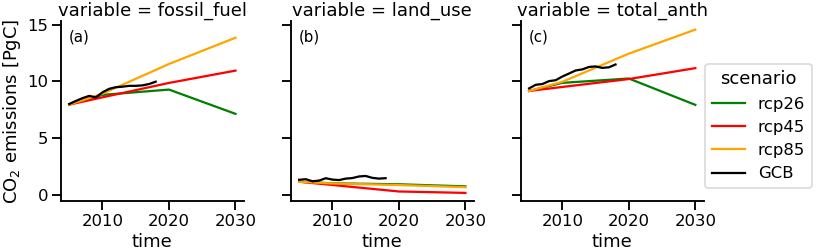

In [37]:
with sb.color_palette(["green", "red", "orange", "black"]):
    p = emissions.sel(time=slice(2005,2030)).to_array().plot.line(hue='scenario',col='variable',figsize=(10,4))
    sb.despine()
    p.axes[0,0].set_ylabel('CO$_2$ emissions [PgC]')
    set_label(p.axes)
    plt.savefig(paper_path+'FigureSI_emissions',bbox_inches='tight')

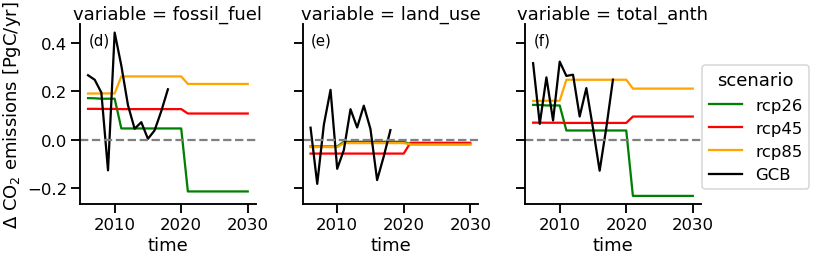

In [38]:
with sb.color_palette(["green", "red", "orange", "black"]):
    p = emissions.sel(time=slice(2005,2030)).diff('time').to_array().plot.line(hue='scenario',col='variable',figsize=(10,4))
    sb.despine()
    p.axes[0,0].set_ylabel('$\Delta$ CO$_2$ emissions [PgC/yr]')
    for ax in p.axes.flatten():
        ax.axhline(y=0,c='gray',ls='--')
    set_label(p.axes,start=3)
    plt.savefig(paper_path+'FigureSI_emissions_change',bbox_inches='tight')

## atm. CO$_2$ forcing

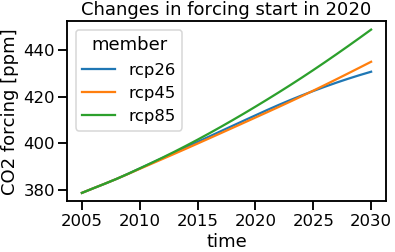

In [39]:
end=2030
co2atm_forcing.sel(time=slice(2005,end)).to_dataframe().unstack(0)['co2atm'].plot(title='Changes in forcing start in 2020')
plt.ylabel('CO2 forcing [ppm]')
plt.tight_layout()
#plt.savefig('co2_forcing')

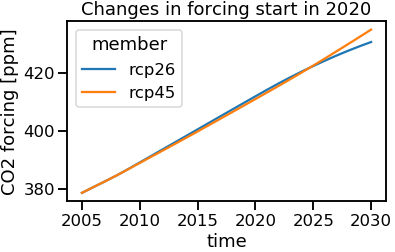

In [40]:
end=2030
co2atm_forcing.sel(member=['rcp26','rcp45']).sel(time=slice(2005,end)).to_dataframe().unstack(0)['co2atm'].plot(title='Changes in forcing start in 2020')
plt.ylabel('CO2 forcing [ppm]')
plt.tight_layout()
#plt.savefig('co2_forcing')

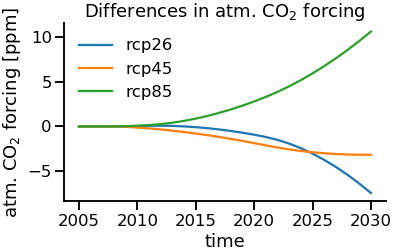

In [41]:
(co2atm_forcing-co2atm_forcing.mean('member')).sel(time=slice(2005,end)).to_dataframe().unstack(0)['co2atm'].plot(title='Differences in atm. CO$_2$ forcing')
plt.ylabel('atm. CO$_2$ forcing [ppm]')
plt.tight_layout()
plt.legend(frameon=False)
sb.despine()
#plt.savefig('co2_forcing_diff2')
plt.show()

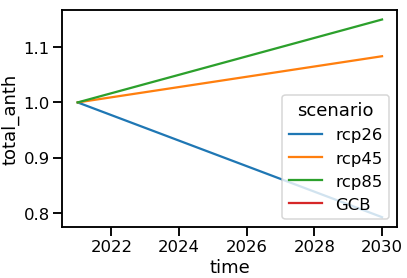

In [42]:
n = emissions.sel(time=slice(2021,2030))

n /= n.isel(time=0)

n['total_anth'].plot(hue='scenario')

## harmonization of emissions before emission cut date

#### emission cuts in 2020
align RCP2.6 and RCP8.5 before 2020

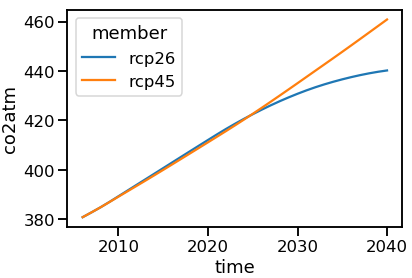

In [43]:
co2atm_forcing_2 = co2atm_forcing.sel(time=slice(2006,2040)).drop_sel(member='rcp85')['co2atm']
co2atm_forcing_2.plot.line(hue='member')

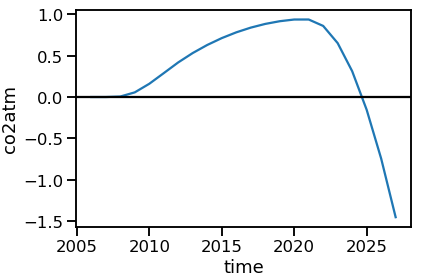

In [44]:
scenario_difference = (co2atm_forcing_2.sel(member='rcp26')-co2atm_forcing_2.sel(member='rcp45'))
scenario_difference.sel(time=slice(None,2027)).plot()
plt.axhline(y=0,c='k')

In [45]:
positive_until_index = co2atm_forcing_2.diff('member').argmin('time')
positive_until_index

<xarray.DataArray 'co2atm' (member: 1)>
array([15])
Coordinates:
  * member   (member) object 'rcp45'

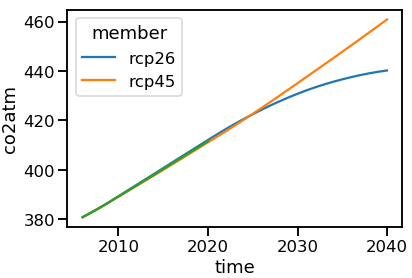

In [46]:
co2atm_forcing_2.plot.line(hue='member')
co2atm_forcing_2.isel(time=slice(None,int(positive_until_index.values))).mean('member').plot()

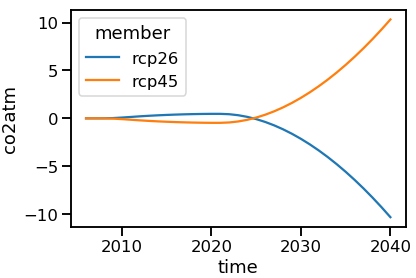

In [47]:
(co2atm_forcing_2-co2atm_forcing_2.mean('member')).plot.line(hue='member')

In [48]:
co2atm_forcing_2.where((np.abs((co2atm_forcing_2-co2atm_forcing_2.mean('member')).diff('member'))<=0.2),drop=True).time.max()

<xarray.DataArray 'time' ()>
array(2025)

In [49]:
co2atm_forcing_harm = xr.concat([co2atm_forcing_2.sel(time=slice(None,2025)).mean('member'),co2atm_forcing_2.sel(time=slice(2026,None))],dim='time').to_dataset(name='co2atm')

Text(0.5, 1.0, 'harmonized before 2025')

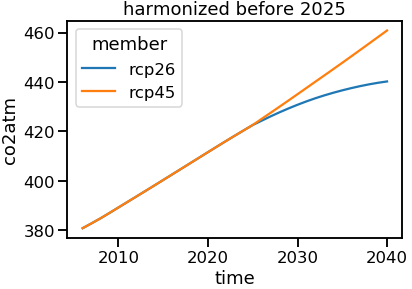

In [50]:
co2atm_forcing_harm['co2atm'].plot.line(hue='member')
plt.title('harmonized before 2025')

Text(0.5, 1.0, 'raw')

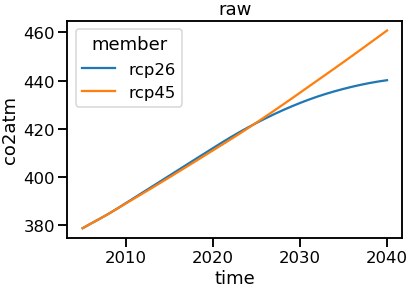

In [51]:
co2atm_forcing.sel(time=slice(2005,2040)).drop_sel(member='rcp85')['co2atm'].plot.line(hue='member')
plt.title('raw')

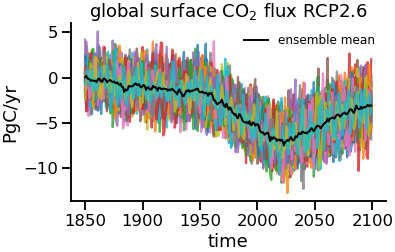

In [52]:
v = 'co2_flux'
cf.isel(member=0)[v].to_dataframe().unstack().plot(legend=False,alpha=.8)
m = cf.isel(member=0)[v].mean('initialization').plot(label='ensemble mean',color='k',lw=2,ax=plt.gca())
plt.title('global surface CO$_2$ flux RCP2.6')
plt.ylabel('PgC/yr')
plt.legend(m,['ensemble mean'],fontsize=12, frameon=False)
plt.tight_layout()
sb.despine()
#plt.savefig('co2_flux_evolution')

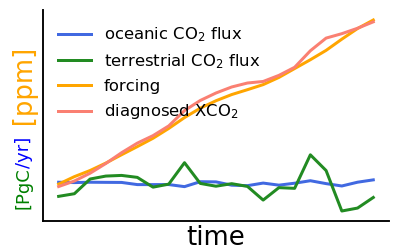

In [53]:
start = 1980
end = 2000
lw = 3
iv = (cf['co2_flx_ocean'] - cf['co2_flx_ocean'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
(iv*2).plot(color='royalblue',lw=lw,label='oceanic CO$_2$ flux')
iv = (cf['co2_flx_land'] - cf['co2_flx_land'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
(iv*2).plot(color='forestgreen',lw=lw, label='terrestrial CO$_2$ flux')
iv = (cf['co2_flux'] - cf['co2_flux'].mean('initialization')).isel(initialization=0,member=0).sel(time=slice(start,end))
f = (co2atm_forcing['co2atm'] - co2atm_forcing['co2atm'].sel(time=start)).isel(member=0).sel(time=slice(start,end))
f.plot(color='orange',lw=lw, label='forcing')
comb=f+iv.cumsum('time')/2.12
comb.plot(color='salmon',lw=lw,label='diagnosed XCO$_2$')
plt.ylabel('       [ppm]',color='orange',fontsize='x-large')
plt.title('')
plt.xlabel('time',fontsize='x-large')
plt.legend(frameon=False)
plt.xticks([], [])
plt.yticks([], [])
x = 0.037
plt.annotate('/yr]',xy=(x, 0.4), 
             xycoords='figure fraction',
             rotation=90,
             fontsize='medium',
             color='blue'
            )
plt.annotate('[PgC',xy=(x, 0.28), 
             xycoords='figure fraction',
             rotation=90,
             fontsize='medium',
             color='green'
            )
plt.tight_layout()
sb.despine()
plt.savefig(paper_path+'FigureSI_diag_atm_CO2_schema')

### Investigating internal variability

In [54]:
#first removing drift with subtracting rolling 50 yr mean
roll = 50
rolld2 = roll//2
cf_internal_variability = cf - cf.rolling(time=roll,center=True).mean().isel(time=slice(rolld2,-rolld2))
cf_internal_variability = cf_internal_variability - cf_internal_variability.mean('initialization')

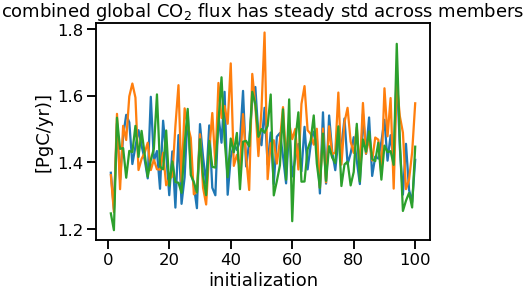

In [55]:
cf_internal_variability.std('time').to_dataframe()['co2_flux'].unstack().plot(legend=False,title='combined global CO$_2$ flux has steady std across members')
plt.ylabel('[PgC/yr)]')
plt.show()

# Diagnosing atmospheric CO$_2$ concentrations
Two methodologies:
- initialize each member inidividually where going through 0
- initialize all

Inventory change in Ocean/Land at the atmospheric surface result in atmospheric CO2 inventory and thereby change atm. CO2 concentration.

As atm. CO2 is prescribed in historical simulations, I diagnose the internal variability of CO$_2$ from the time-accumulated internal variability of the global surface CO$_2$ fluxes. 

Assuming that global CO$_2$ fluxes in PgC=GtC spread in the global atmosphere: 1ppm = 2.12 GtC = 2.12 PgC [Le Quere2018, Doney2006, many others]

Formula:

$pCO_{2,atm,diag}(t) = pCO_{2,atm,forcing}(t) + \sum^t_{t'=1850} \overline{\text{CO$_2$ flux}(t')}\frac{ppm}{2.12PgC}$

The $\overline{\text{overline}}$ denotes zero-mean, zero-trend CO$_2$ flux which is achieved by remove the ensemble member mean and time mean. 

Assumptions:
- atm. CO$_2$ concentrations are driven by emissions and the carbon feedbacks. Inter-annual variability (with the forced signal removed) is due to climate variability only.
- feedback of internal variability of atm. CO$_2$ on CO$_2$ fluxes is negligible:
  - CO$_2$ flux variability is driven by large-scale modes of internal climate variability
  - this assumption also made in CMIP5 historical simulations
- inter-annual variability of atm. CO$_2$ doesn't affect radiation scheme:
  - this assumption is also made in CMIP5 historical simulations

## Diagnose by initializing each member at equil. cum. CO2 flux

In [56]:
fac = 2.13
v='co2_flux'

In [57]:
# initialize every member at its own carbon neutral time in historical (therefore member=0)
flex_inits = cf_internal_variability.isel(member=0).drop('member')[v].sel(time=slice(1850,2005))

Text(0, 0.5, 'PgC/yr')

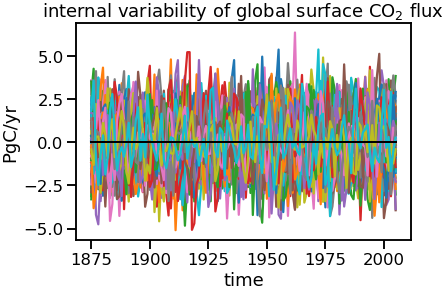

In [58]:
flex_inits.to_dataframe().unstack().plot(legend=False)
flex_inits.mean('initialization').to_dataframe().plot(legend=False,color='k',lw=2,ax=plt.gca())
plt.title('internal variability of global surface CO$_2$ flux')
plt.ylabel('PgC/yr')

In [59]:
# standardize to find close to neutral easier
standardized = (flex_inits-flex_inits.mean('time'))/flex_inits.std('time')
#standardized.to_dataframe().unstack().plot(legend=False)

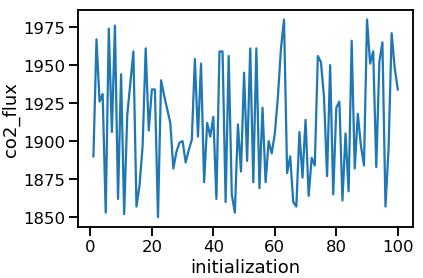

In [60]:
# where every member is close to carbon neutral (defined as less than .1*std away)
(standardized.where(np.abs(standardized)<.1).argmax('time')+1850).plot()

In [61]:
def find_neutral_IC(cf,v='co2_flux',i=1,diff=.1):
    """Find neutral detrended co2_flux cumsum (smaller than diff*std) initial conditions year."""
    # for each member individually
    onem = (cf - cf.mean('initialization')).isel(member=0).isel(initialization=i).sel(time=slice(1850,2005))[v]
    onem = onem - onem.mean('time')
    # aggregate over time
    onemc = (onem).cumsum('time')/2.13
    onemc['time'] = onem.time
    from PMMPIESM.variability import standardize
    onemc_std = standardize(onemc)
    return onemc_std.where(np.abs(onemc_std)<diff).dropna('time').time.values[-1]

In [62]:
neutral_year=dict()
for i in range(0,100):
    res = find_neutral_IC(cf,i=i)
    print(i,res)
    neutral_year[i+1] = res

0 1995
1 1997
2 2003
3 2002
4 2004
5 1994
6 1996
7 2005
8 1982
9 1971
10 1983
11 2000
12 1975
13 1992
14 1991
15 2003
16 2005
17 2001
18 2000
19 2001
20 2001
21 1966
22 2003
23 1942
24 1951
25 2005
26 2000
27 1987
28 1949
29 2004
30 1994
31 1992
32 1987
33 1953
34 2001
35 1972
36 1978
37 2005
38 2002
39 2002
40 1995
41 1998
42 1991
43 2003
44 2004
45 1986
46 1990
47 2005
48 1984
49 1985
50 2004
51 1987
52 1926
53 1981
54 1974
55 1964
56 2004
57 2005
58 1998
59 1994
60 2000
61 2000
62 2005
63 1957
64 1987
65 2003
66 2003
67 1986
68 2003
69 1987
70 2004
71 1991
72 1992
73 1988
74 1995
75 2003
76 1993
77 2005
78 2005
79 1919
80 2005
81 1994
82 1987
83 1999
84 1997
85 2002
86 2005
87 1995
88 1983
89 1986
90 2003
91 1999
92 1997
93 1995
94 2002
95 1967
96 1956
97 1967
98 1996
99 1996


In [63]:
def individual_init(cf_internal_variability,i=90,plot=False):
    """Initialize a member i in its latest carbon neutral year in the historical."""
    end = 2070
    c = cf_internal_variability.sel(initialization=i).isel(member=0)[v]
    if plot:
        c.plot()

    init = (c).sel(time=slice(neutral_year[i]+1,2004)).sum('time')/2.13
    #   member, initialized in 2005 value, neutral year
    print(i, init.values, neutral_year[i])
    # units:        ppm                                          ppm        ppm
    d = co2atm_forcing['co2atm'].sel(time=slice(2005,end)) + init.values + cf_internal_variability.sel(time=slice(2005,end)).sel(initialization=i).cumsum('time')/2.13
    d['time'] = cf_internal_variability.sel(time=slice(2005,end)).time

    if plot:
        d.to_dataframe().unstack(0)[v].plot()
    return d

In [64]:
# initialize every member
res = []
for i in cf_internal_variability.initialization.values:
    res.append(individual_init(cf_internal_variability,i=i))
diagnosed = xr.concat(res,'initialization')
diagnosed['initialization'] = cf_internal_variability.initialization.values

1 0.24404741990514595 1995
2 -3.110839526483232 1997
3 0.0429582419294559 2003
4 0.984090041602762 2002
5 0.0 2004
6 0.7170623895427034 1994
7 -1.1334142111626242 1996
8 0.0 2005
9 -0.8269483273120529 1982
10 -2.6118339526242558 1971
11 0.6290315225533255 1983
12 -1.289022083774778 2000
13 1.120819144876233 1975
14 1.181676151183098 1992
15 -0.3967021302170552 1991
16 -0.3894153519900103 2003
17 0.0 2005
18 -0.45829132734283645 2001
19 0.960625176216671 2000
20 -2.4850746999696263 2001
21 -0.2482901376435326 2001
22 -0.864163417022472 1966
23 1.2108910585747463 2003
24 -1.551246030669956 1942
25 1.6995040643215824 1951
26 0.0 2005
27 -0.7286782600933425 2000
28 -0.6316182333337012 1987
29 1.9841335968097538 1949
30 0.0 2004
31 -1.528951755940444 1994
32 -0.4852433435748547 1992
33 1.7823480037278763 1987
34 0.03430809119501586 1953
35 2.247651021658513 2001
36 2.3926354198834776 1972
37 1.10327387273546 1978
38 0.0 2005
39 -1.5765319781926326 2002
40 -1.324659094429881 2002
41 0.244833

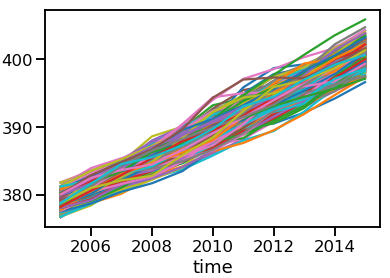

In [65]:
v='co2_flux'
diagnosed.sel(time=slice(2005,2015))[v].to_dataframe().unstack(0).unstack(0)[v].plot(legend=False)

In [66]:
diagnosed_int_var = (diagnosed-co2atm_forcing['co2atm'])

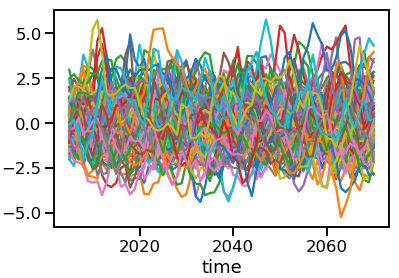

In [67]:
diagnosed_int_var['co2_flux'].isel(member=1).to_dataframe()['co2_flux'].unstack(0).plot(legend=False)

,diag. atm. CO$_2$
count,100.00
mean,-0.00
std,1.09
min,-2.07
25%,-0.77
50%,-0.01
75%,0.68
max,2.94


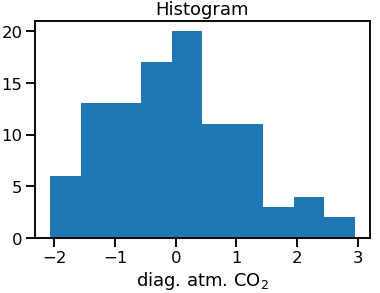

In [68]:
# distribution of diagnosed atm CO2 in 2005
hist = (diagnosed - diagnosed.mean('initialization')).sel(time=slice(2005, 2005)).sel(member=['rcp45'])['co2_flux']
hist.name = 'diag. atm. CO$_2$'
hist.plot.hist()
hist.to_dataframe().describe().round(2)

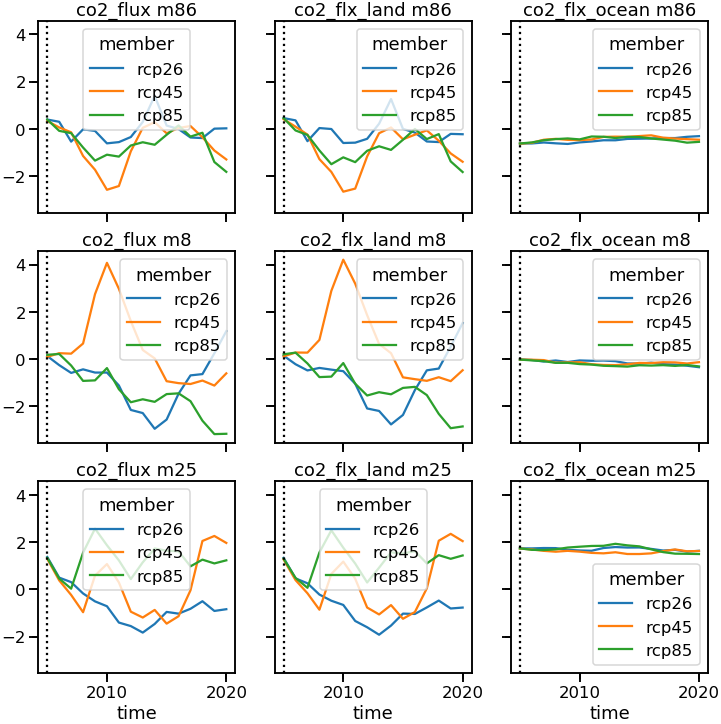

In [69]:
# quick check on individual members
int_var=True
n=3
random_members = np.random.randint(1,100,n)
#varname = 'ocean'
fig,ax=plt.subplots(ncols=3,nrows=n,figsize=(3*4,n*4),sharex=True,sharey=True)
for i,m in enumerate(random_members):
    if int_var:
        t=diagnosed_int_var
    else:
        t=diagnosed
    for j,varname in enumerate(t.data_vars):
        t.sel(initialization=m)[varname].drop('initialization').sel(time=slice(2000,2020)).to_dataframe()[varname].unstack(0).plot(title=' '.join([varname,'m'+str(m)]),ax=ax[i,j])
        ax[i,j].axvline(x=2005,ls=':',c='k')

In [70]:
diagnosed_harm = diagnosed-co2atm_forcing['co2atm']+co2atm_forcing_harm['co2atm']

In [84]:
diagnosed.to_netcdf(data_path+'GE_diagnosed_atm_CO2.nc')

In [85]:
diagnosed = xr.open_dataset(data_path+'GE_diagnosed_atm_CO2.nc')

In [86]:
def diagnose_early_to_2004(cf_internal_variability,diagnosed,i=2,s=1880,e=2005):
    """Diagnose atm. CO$_2$ for historical period initialized with the 2005 values."""
    init = diagnosed.sel(time=2005)['co2_flux'].isel(member=0) - co2atm_forcing['co2atm'].sel(time=2005,member='rcp26').values
    diag_before = co2atm_forcing['co2atm'].sel(time=slice(s,e)) + init + cf_internal_variability.sel(time=slice(s,e)).cumsum('time')/2.13
    diag_before['time'] = cf_internal_variability.sel(time=slice(s,e)).time
    # adjust diag_before to diagnosed
    offset = diagnosed['co2_flux'].isel(member=0).sel(time=2005).squeeze() - diag_before['co2_flux'].isel(member=0).sel(time=2005).squeeze()
    diag_before = diag_before + offset
    return diag_before

diagnosed_all=xr.concat([diagnose_early_to_2004(cf_internal_variability,diagnosed,i=2).sel(time=slice(1880,2004)),diagnosed],'time')

## Figure 1

In [87]:
import PMMPIESM
# donwload data
GM=PMMPIESM.load.CO2_global_mean().groupby('time.year').mean('time').rename({'year':'time'})
GMGR = GM.diff('time').to_dataframe('GM')
MLO=PMMPIESM.load.CO2_Mauna_Loa().groupby('time.year').mean('time').rename({'year':'time'})
MLOGR=MLO.sel(time=slice('1980',None)).diff('time').to_dataframe('MLO')

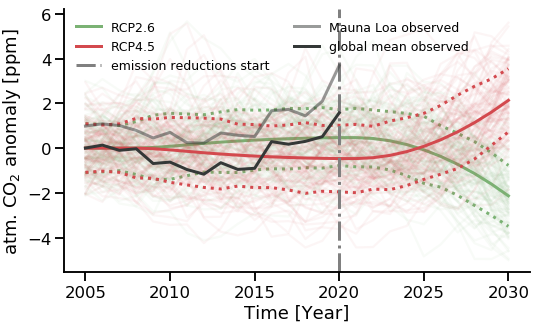

In [88]:
colors = ["faded green", "faded red", "charcoal"]
cmap=sb.xkcd_palette(colors)

end=2030
forcing = 0
forcing = diagnosed['co2_flux'].sel(time=slice(2005,end)).isel(member=[0,1]).mean('member').mean('initialization')
fig,ax=plt.subplots(figsize=(8,5))
handles=[]
for i in range(2):
    (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).to_dataframe()['co2_flux'].unstack(0).plot(ax=ax,alpha=.05, c=cmap[i],legend=False)
    mean = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).mean('initialization')
    std = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).std('initialization')
    m,=mean.plot(c=cmap[i],lw=3)
    handles.append(m)
    (mean+std).plot(c=cmap[i],lw=3,ls=':')
    (mean-std).plot(c=cmap[i],lw=3,ls=':')
ms=ax.axvline(x=2020,ls='-.',lw=3,c='gray')

#obs
gmo,=(GM-forcing).plot(c=cmap[2],lw=3)
mlo,=(MLO-forcing).plot(c=cmap[2],lw=3,alpha=.5)

ax.legend(handles+[ms,mlo,gmo],['RCP2.6','RCP4.5','emission reductions start','Mauna Loa observed','global mean observed'],
          frameon=False,ncol=2, fontsize='x-small')
sb.despine()
plt.ylabel('atm. CO$_2$ anomaly [ppm]')
plt.xlabel('Time [Year]')
plt.tight_layout()
plt.savefig(paper_path+'Figure1_co2_forcing_diff.png')

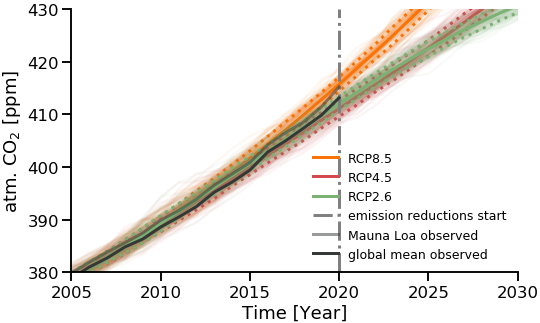

In [89]:
colors = ["faded green", "faded red", "orange", "charcoal"]
cmap=sb.xkcd_palette(colors)

end=2030
forcing = 0
#forcing = diagnosed['co2_flux'].sel(time=slice(2005,end)).isel(member=[0,1]).mean('member').mean('initialization')
fig,ax=plt.subplots(figsize=(8,5))
handles=[]
for i in [2,1,0]:
    (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).to_dataframe()['co2_flux'].unstack(0).plot(ax=ax,alpha=.05, c=cmap[i],legend=False)
    mean = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).mean('initialization')
    std = (diagnosed-forcing)['co2_flux'].sel(time=slice(2005,end)).isel(member=i).std('initialization')
    m,=mean.plot(c=cmap[i],lw=3)
    handles.append(m)
    (mean+std).plot(c=cmap[i],lw=3,ls=':')
    (mean-std).plot(c=cmap[i],lw=3,ls=':')
ms=ax.axvline(x=2020,ls='-.',lw=3,c='gray')

#obs
gmo,=(GM-forcing).plot(c=cmap[3],lw=3)
mlo,=(MLO-forcing).plot(c=cmap[3],lw=3,alpha=.5)

plt.ylim([380,430])
plt.xlim([2005,2030])

ax.legend(handles+[ms,mlo,gmo],['RCP8.5','RCP4.5','RCP2.6','emission reductions start','Mauna Loa observed','global mean observed'],
          frameon=False,ncol=1, fontsize='x-small')
sb.despine()
plt.ylabel('atm. CO$_2$ [ppm]')
plt.xlabel('Time [Year]')
plt.tight_layout()
plt.savefig(paper_path+'FigureSI_co2_forcing.png')

## Figure SI1: Verification of diagnosed

In [90]:
def diagnose_emission_driven(ds):
    co2_flux = ds['co2_flux']
    co2_flux = co2_flux-co2_flux.mean('member')
    non_zero_comp = co2_flux.sel(time=slice('1850','1870')).mean(['time','member'])
    #print(non_zero_comp)
    co2_flux = co2_flux - non_zero_comp
    diag = co2_flux.cumsum('time')/2.12
    ds['diagnosed'] = diag + ds['CO2'].mean('member')
    return ds

In [91]:
d=yearmonmean(diagnose_emission_driven(c4mip)['diagnosed'])

In [92]:
c4mip_ym = yearmonmean(c4mip)

In [93]:
forcing=c4mip_ym['CO2'].mean('member')
#forcing=0

member 1 ACC 0.997 RMSE 0.152 MAE 0.134
member 2 ACC 0.998 RMSE 0.091 MAE 0.076
member 3 ACC 0.989 RMSE 0.167 MAE 0.139
member 4 ACC 0.992 RMSE 0.130 MAE 0.109
member 5 ACC 0.994 RMSE 0.142 MAE 0.129
member 6 ACC 0.993 RMSE 0.146 MAE 0.118
member 7 ACC 0.991 RMSE 0.137 MAE 0.113
member 8 ACC 0.995 RMSE 0.165 MAE 0.147
member 9 ACC 0.995 RMSE 0.224 MAE 0.207


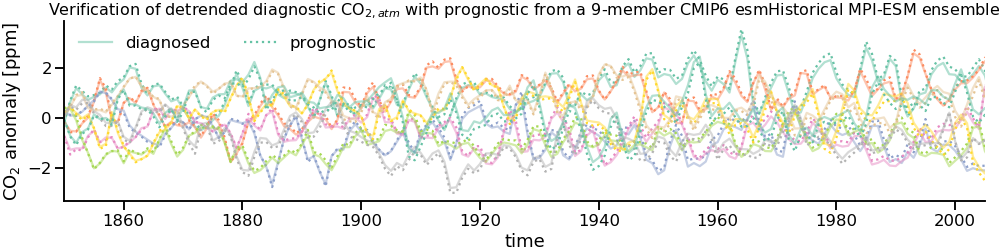

In [94]:
import xskillscore as xs
r_mae=[]
r_rmse=[]
r_pearson_r=[]
cmap = sb.color_palette('Set2',c4mip.member.size)
fig,ax=plt.subplots(figsize=(15,4))
for i,m in enumerate(d.member):
    #print(m.values)
    a=d.sel(member=m)-forcing
    p1=a.plot(label='diagnosed',c=cmap[i],alpha=.5)
    b=c4mip_ym.sel(member=m)['CO2']-forcing
    b=b-b.isel(time=0)+a.isel(time=0)
    p2=b.plot(label='prognostic',c=cmap[i],ls=':')
    plt.title(int(m.values))
    r=xs.mae(a,b,'time')
    #print(f"mae {r.values:.3f}")
    r_mae.append(r)
    r=xs.rmse(a,b,'time')
    #print(f"rmse {r.values:.3f}")
    r_rmse.append(r)
    r=xs.pearson_r(a,b,'time')
    print(f"member {int(m)} ACC {r.values:.3f} RMSE {r_rmse[-1].values:.3f} MAE {r_mae[-1].values:.3f}")
    r_pearson_r.append(r)
plt.ylabel('CO$_2$ anomaly [ppm]')
plt.title('Verification of detrended diagnostic CO$_{2,atm}$ with prognostic from a '+str(int(c4mip_ym.member.size))+'-member CMIP6 esmHistorical MPI-ESM ensemble',fontsize=16)
plt.legend()
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=2, frameon=False)
plt.xlim([1850,2005])
sb.despine()
plt.tight_layout()
plt.savefig(paper_path+'FigureSI_Verification_diagnosed')

In [95]:
r_mae = xr.concat(r_mae,'member')
r_rmse = xr.concat(r_rmse,'member')
r_pearson_r = xr.concat(r_pearson_r,'member')

df=xr.concat([r_mae,r_rmse,r_pearson_r],'metric')
df['metric']=['MAE','RMSE','ACC']
df=df.to_dataframe('res').unstack(0)

df.describe().round(3)

res              
metric    ACC    MAE   RMSE
count   9.000  9.000  9.000
mean    0.994  0.130  0.150
std     0.003  0.036  0.035
min     0.989  0.076  0.091
25%     0.992  0.113  0.137
50%     0.994  0.129  0.146
75%     0.995  0.139  0.165
max     0.998  0.207  0.224

In [96]:
# difference of each member towards anomaly
c=(c4mip_ym-c4mip_ym.mean('member'))['CO2']
c.to_dataframe().unstack().describe().round(2)

CO2                                                                
member       1       2       3       4       5       6       7       8       9
count   165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00  165.00
mean      0.56    0.34    0.00   -0.40   -0.07   -0.18   -0.09   -0.52    0.37
std       0.76    0.82    0.76    0.66    0.55    0.87    0.64    0.77    0.79
min      -1.20   -2.33   -2.06   -1.76   -1.30   -2.75   -1.51   -2.57   -1.84
25%       0.09   -0.24   -0.56   -0.84   -0.45   -0.69   -0.57   -1.07   -0.09
50%       0.54    0.45    0.11   -0.37   -0.12   -0.13   -0.08   -0.58    0.40
75%       1.14    0.93    0.57    0.04    0.33    0.37    0.41    0.01    0.91
max       2.82    2.16    1.75    1.74    1.35    1.78    1.45    1.13    2.45

# Trend mitigation probabilities [Marotzke 2019]
Event: climate response = decrease in iconic climate variable over 2021-2035 compared to 2006-2020

In [97]:
# renaming to time, init, member to work in xarray only
# gmst_cdo2 = gmst_cdo.rename({'year':'time'})

In [98]:
cf2 = cf.copy().rename({'member':'ext'}).rename({'initialization':'member'})

In [99]:
diagnosed2 = diagnosed.copy().rename({'member':'ext'}).rename({'initialization':'member',
                                                               'co2_flux':'diag_CO2',
                                                               'co2_flx_ocean':'diag_CO2_ocean',
                                                               'co2_flx_land':'diag_CO2_land'})[['diag_CO2']]

In [100]:
diagnosed_all2 = diagnosed_all.copy().rename({'member':'ext'}).rename({'initialization':'member',
                                                               'co2_flux':'diag_CO2',
                                                               'co2_flx_ocean':'diag_CO2_ocean',
                                                               'co2_flx_land':'diag_CO2_land'})[['diag_CO2']]

In [101]:
diagnosed_harm2 = diagnosed_harm.copy().rename({'member':'ext'}).rename({'initialization':'member',
                                                               'co2_flux':'diag_CO2',
                                                               'co2_flx_ocean':'diag_CO2_ocean',
                                                               'co2_flx_land':'diag_CO2_land'})[['diag_CO2']]

In [102]:
from scipy.stats import linregress
def xr_linear_trend(ds,dim):
    """Return the linear trend (slope * trendlength)."""
    return xr.apply_ufunc(
        linregress,
        ds[dim],
        ds,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask="allowed",
    )[0]*ds[dim].size

In [103]:
# %timeit xr_linear_trend(cf,'time')

In [104]:
print_res=True
def xr_concat_trends(ds,start=2006,mitigation_date=2020,end=2035,dim='time'):
    """Calc all trends between start and end for mitigation_date possible and concat."""
    mid = int((end-start+1)/2+start)-1
    assert mid == mitigation_date
    max_trendlength=int((end-start+1)/2)
    
    early_list=[]
    late_list=[]
    period_list=[]
    length=[]
    for i,i_start_year in enumerate(np.arange(start,mitigation_date-1)):
        i_trendlength = mid-i_start_year+1
        i_end_year = mid+i_trendlength
        early = xr_linear_trend(ds.sel({dim:slice(i_start_year,mid)}),dim=dim)
        late = xr_linear_trend(ds.sel({dim:slice(mid+1,i_end_year)}),dim=dim)
        print('Trends',i_start_year,'-',mid,mid+1,'-',i_end_year, 'Trendlength:', i_trendlength)
        early_list.append(early)
        late_list.append(late)
        period_list.append(f'{i_start_year}-{i_end_year}')
        length.append(i_trendlength)
    early = xr.concat(early_list,'trendlength')
    late = xr.concat(late_list,'trendlength')
    periods = xr.concat([early,late],'timing')
    periods['timing'] = ['before','after']
    periods['periods'] = period_list
    periods['trendlength'] = length
    return periods.sortby('trendlength')

In [105]:
def xr_trend_probability(trends, event='weaker'):
    # whats a successful climate mitigation event?
    """Trends from `xr_concat_trends` to probability in %."""
    trend_late = trends.sel(timing='after')
    trend_early = trends.sel(timing='before')
    if event=='stronger':
        diff = trend_late - trend_early
    elif event=='weaker':
        diff = trend_early - trend_late
    else:
        raise ValueError('not impl')
    P=(diff>0).sum('member')/trends.member.size
    return P

In [106]:
from tqdm import trange
def bootstrapping(ds,func,dim='member',bootstrap=5, replacement=True, **func_kwargs):
    bootstraped_results = []
    dim_to_shuffle = ds[dim].values
    length = len(dim_to_shuffle)//2
    for _ in trange(bootstrap):
        if replacement:
            smp_dim = np.random.choice(dim_to_shuffle, len(dim_to_shuffle))
        else:
            dim_to_shuffle = ds[dim].values
            smp_dim = np.random.choice(dim_to_shuffle, replace=False, size=length)
            dim_to_shuffle = ds[dim].isel({dim:slice(None,length)}).values
        smp_ds = ds.sel({dim:smp_dim})
        smp_ds[dim] = dim_to_shuffle
        b_res=func(smp_ds, **func_kwargs)
        bootstraped_results.append(b_res)
    res = xr.concat(bootstraped_results, 'bootstrap')#.quantile( sig / 100, 'bootstrap')
    return res

In [107]:
v='diag_CO2'
trends = xr_concat_trends(diagnosed2)
P = bootstrapping(trends, xr_trend_probability, bootstrap=500)

Trends 2006 - 2020 2021 - 2035 Trendlength: 15
Trends 2007 - 2020 2021 - 2034 Trendlength: 14
Trends 2008 - 2020 2021 - 2033 Trendlength: 13
Trends 2009 - 2020 2021 - 2032 Trendlength: 12
Trends 2010 - 2020 2021 - 2031 Trendlength: 11
Trends 2011 - 2020 2021 - 2030 Trendlength: 10
Trends 2012 - 2020 2021 - 2029 Trendlength: 9
Trends 2013 - 2020 2021 - 2028 Trendlength: 8
Trends 2014 - 2020 2021 - 2027 Trendlength: 7
Trends 2015 - 2020 2021 - 2026 Trendlength: 6
Trends 2016 - 2020 2021 - 2025 Trendlength: 5
Trends 2017 - 2020 2021 - 2024 Trendlength: 4


  7%|▋         | 36/500 [00:00<00:01, 354.53it/s]

Trends 2018 - 2020 2021 - 2023 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 336.77it/s]


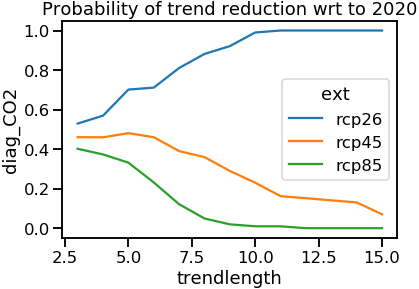

In [108]:
P[v].mean('bootstrap').plot.line(hue='ext')
plt.title('Probability of trend reduction wrt to 2020')
plt.show()

In [109]:
def P_to_P_causual(event_summary, mitigation_scenario='rcp26',no_mitigation_scenarios=['rcp45','rcp85']):
    if isinstance(no_mitigation_scenarios, str):
        no_mitigation_scenarios = [no_mitigation_scenarios]
    P_list=[]
    for comparison_no_mitigation in no_mitigation_scenarios:
        P_mit = event_summary.sel(ext=mitigation_scenario,drop=True)
        P_no_mit = event_summary.sel(ext=comparison_no_mitigation,drop=True)
        P_S = (P_mit - P_no_mit) / (1 - P_no_mit)
        P_N = 1 - (P_no_mit / P_mit)
        P_NS = P_mit - P_no_mit
        P_list.append(xr.concat([P_S, P_N, P_NS, P_mit, P_no_mit],dim='P'))
    P = xr.concat(P_list,'comparison')
    P['P'] = ['P_S', 'P_N', 'P_NS','P_mit', 'P_no_mit']
    comparison_list = [f'{mitigation_scenario}_vs_{no_mit}' for no_mit in no_mitigation_scenarios]
    P['comparison'] = comparison_list#['rcp2.6_vs_rcp4.5','rcp2.6_vs_rcp8.5']
    P = P.squeeze() * 100 # convert to %
    # correct for neg values: not needed?!
    P = P.where(P >= 0, other=0) 
    P = P.where(P <= 100, other=100) 
    return P

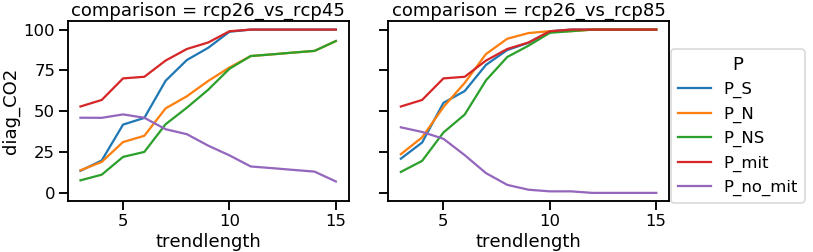

In [110]:
P_to_P_causual(P)[v].mean('bootstrap').plot(hue='P',col='comparison',figsize=(10,4))

In [111]:
psig=.99

In [112]:
def plot_P(P,title='GMST',v='tsurf',ax=None, loc='best',causation=True, box=False, mitigation_start=2020,mitigation_scenario='rcp26', no_mitigation_scenario='rcp45'):
    # transpose needed
    mitigation_scenario = f'{mitigation_scenario[:3].upper()}{mitigation_scenario[-2]}.{mitigation_scenario[-1]}'
    no_mitigation_scenario = f'{no_mitigation_scenario[:3].upper()}{no_mitigation_scenario[-2]}.{no_mitigation_scenario[-1]}'

    P=P[v].transpose(*('trendlength', 'bootstrap', 'P'))
    print(((P.median('bootstrap')>95).argmax('trendlength')+3).to_dataframe(),'ignore P_RCP45 value')
    #  P['P'] = ['P_S', 'P_N', 'P_NS','P_mit', 'P_no_mit']
    mitigation_scenario_str = f'P$_{{'+str(mitigation_scenario)+'}}$'.format(mitigation_scenario)
    no_mitigation_scenario_str = f'P$_{{'+str(no_mitigation_scenario)+'}}$'.format(no_mitigation_scenario)
    P['P'] = ['$P_S$', '$P_N$', '$P_{NS}$', mitigation_scenario_str, no_mitigation_scenario_str]
    if ax is None:
        fig,ax=plt.subplots(figsize=(8,5))
    colors = ["baby blue", "medium blue", "dark blue", "faded green", "faded red"]
    cmap=sb.xkcd_palette(colors)
    fac=1
    mean = P.median('bootstrap')*fac
    ul = P.quantile(psig,'bootstrap')*fac
    ll = P.quantile(1-psig,'bootstrap')*fac
    res_Marotzke2019=[40,33,22,67,45]
    df=mean.to_dataframe()[v].unstack()
    
    for i,iP in enumerate(P.P.values):
        yerr = [ll.to_dataframe()[v].unstack()[iP]-df[iP],df[iP]-ul.to_dataframe()[v].unstack()[iP]]
        if causation:
            df[iP].plot(yerr=yerr,capsize=4,c=cmap[i],marker='o',ax=ax)
        else:
            if iP in [mitigation_scenario_str, no_mitigation_scenario_str]:
                df[iP].plot(yerr=yerr,capsize=4,c=cmap[i],marker='o',ax=ax)
    #ax=plt.gca()
    ax.set_title(title)
    ax.set_ylim([-5,105])
    ax.set_ylabel('Probability P [%]')
    ax.set_xlabel(f'Trend length [years] around {mitigation_start}')
    #ax.axhline(y=50,c='gray',label='')
    ax.set_xlim([df.index.min()-1,df.index.max()+1])
    ax.set_xticks(np.arange(df.index.min(),df.index.max()+1))
    if causation:
        ncol = 2
        legendtitle = 'Causation: Trend reduction:'
    else:
        ncol = 1
        legendtitle = 'Trend reduction:'
    ax.legend(ncol=ncol, fontsize='small', frameon=False, loc=loc,
              title=legendtitle, title_fontsize='x-small',
              labelspacing=.3, columnspacing=.5)
    if title is 'GMST':
            for i,p in enumerate(P_gmst.P):
                plt.scatter(15,100*res_Marotzke2019[i],marker='x',color=cmap[i])
    ax.axhline(y=int(psig*100),color='gray',ls=':')
    ax.axhline(y=int(100-100*psig),color='gray',ls=':')
    # add box
    if box:
        tdm = ((P.median('bootstrap')>95).argmax('trendlength')+3)#.to_dataframe('TDM')
        tdm = tdm.where(tdm!=3,15)
        fig.patches.extend([plt.Rectangle((.3,0.1),.04,0.65,color='gray',fill=False,transform=fig.transFigure, figure=fig)])
        if causation:
            for i,p in enumerate(['$P_S$','$P_N$']):
                tdm_tl = mean.sel(P=p,trendlength=tdm.sel(P=p)).values
                ax.annotate(f' $D_{p[-2]}$', fontsize='x-small',xy=(tdm.sel(P=p)+.1*(-1)**i, tdm_tl-2*(-1)**i), xytext=(11+i*1.3, 90), xycoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
    
    sb.despine()
    plt.tight_layout()

In [113]:
#plot_P(P_caus,title='Diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=True,box=True)

## comparison of RCP2.6 mitigation vs. RCP4.5 with pot. mitigation start in 2020

In [114]:
def compare_forcing(co2atm_forcing,members=['rcp26','rcp45']):
    fig,ax=plt.subplots(1,2,figsize=(12,4))
    f=co2atm_forcing.sel(member=members).sel(time=slice(2005,2035))
    f.to_dataframe().unstack(0)['co2atm'].plot(ax=ax[0],
        title='Absolute atm. CO$_2$ forcing')
    ax[0].set_ylabel('atm. CO$_2$ forcing [ppm]')
    ax[0].legend(frameon=False)
    (f-f.mean('member')).to_dataframe().unstack(0)['co2atm'].plot(
        title='Differences in atm. CO$_2$ forcing',ax=ax[1])
    ax[1].set_ylabel('atm. CO$_2$ forcing [ppm]')
    ax[1].legend(frameon=False)
    plt.tight_layout()
    sb.despine()

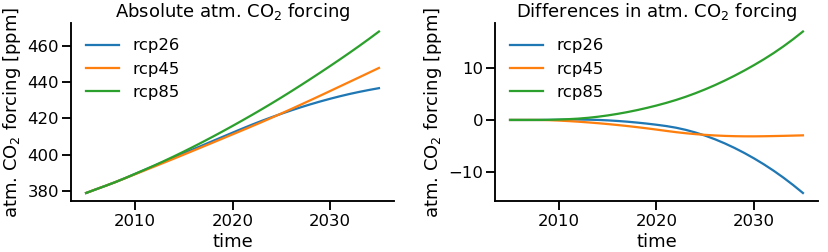

In [115]:
compare_forcing(co2atm_forcing,members=['rcp26','rcp45','rcp85'])

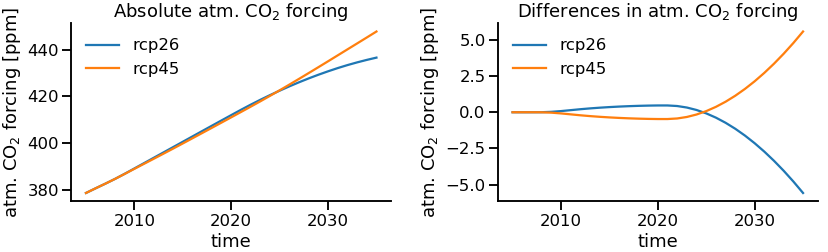

In [117]:
compare_forcing(co2atm_forcing,members=['rcp26','rcp45'])

In [118]:
# vs 4.5
v='diag_CO2'
trends = xr_concat_trends(diagnosed2)
P = bootstrapping(trends, xr_trend_probability, bootstrap=500)
P_caus = P_to_P_causual(P,no_mitigation_scenarios='rcp45')

Trends 2006 - 2020 2021 - 2035 Trendlength: 15
Trends 2007 - 2020 2021 - 2034 Trendlength: 14
Trends 2008 - 2020 2021 - 2033 Trendlength: 13
Trends 2009 - 2020 2021 - 2032 Trendlength: 12
Trends 2010 - 2020 2021 - 2031 Trendlength: 11
Trends 2011 - 2020 2021 - 2030 Trendlength: 10
Trends 2012 - 2020 2021 - 2029 Trendlength: 9
Trends 2013 - 2020 2021 - 2028 Trendlength: 8
Trends 2014 - 2020 2021 - 2027 Trendlength: 7
Trends 2015 - 2020 2021 - 2026 Trendlength: 6
Trends 2016 - 2020 2021 - 2025 Trendlength: 5
Trends 2017 - 2020 2021 - 2024 Trendlength: 4


  7%|▋         | 35/500 [00:00<00:01, 345.85it/s]

Trends 2018 - 2020 2021 - 2023 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 343.85it/s]


              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp45        10
P_N       rcp26_vs_rcp45         3
P_NS      rcp26_vs_rcp45         3
P_mit     rcp26_vs_rcp45        10
P_no_mit  rcp26_vs_rcp45         3 ignore P_RCP45 value


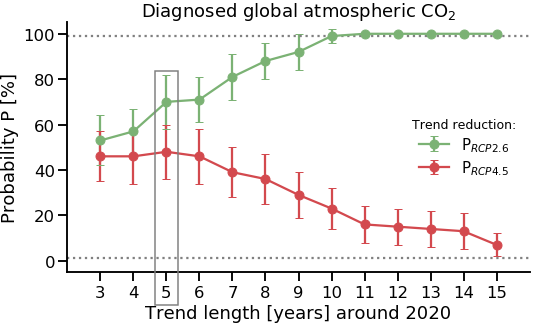

In [119]:
plot_P(P_caus,title='Diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=False,box=True)
plt.savefig(paper_path+'Figure3_pre_Prob_diag_atm_CO2')

              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp45        10
P_N       rcp26_vs_rcp45         3
P_NS      rcp26_vs_rcp45         3
P_mit     rcp26_vs_rcp45        10
P_no_mit  rcp26_vs_rcp45         3 ignore P_RCP45 value


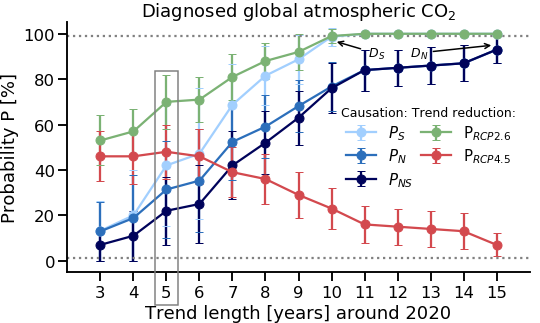

In [120]:
plot_P(P_caus,title='Diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=True,box=True)
plt.savefig(paper_path+'Figure3_Prob_diag_atm_CO2')

## Comparison of RCP2.6 and RCP8.5

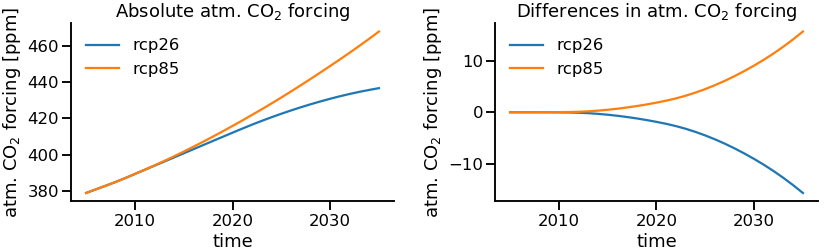

In [121]:
compare_forcing(co2atm_forcing,members=['rcp26','rcp85'])

In [122]:
std = (diagnosed2-diagnosed2.mean('member')).sel(time=slice(None,2008)).sel(ext='rcp85').std(['member','time'])['diag_CO2']

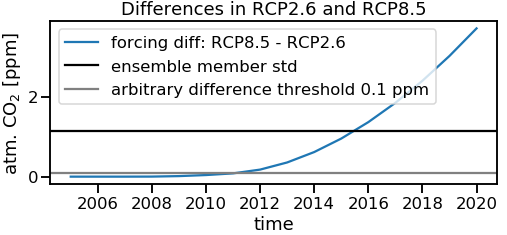

In [123]:
co2atm_forcing.sel(member=['rcp26','rcp85']).diff('member').sel(time=slice(2005,2020)).squeeze()['co2atm'].plot(label='forcing diff: RCP8.5 - RCP2.6',figsize=(8,3))
plt.axhline(y=std,label='ensemble member std',c='k')
plt.axhline(y=.1,label='arbitrary difference threshold 0.1 ppm',c='gray')
plt.ylabel('atm. CO$_2$ [ppm]')
plt.title('Differences in RCP2.6 and RCP8.5')
plt.legend()

In [124]:
# vs 4.5
v='diag_CO2'
diagnosed_all = diagnosed_all.rename({'member':'ext'}).rename({"initialization":'member'}).rename({'co2_flux':'diag_CO2'})

In [139]:
trends = xr_concat_trends(diagnosed_all, mitigation_date=2005,start=1991,end=2020)
P = bootstrapping(trends, xr_trend_probability, bootstrap=500)

Trends 1991 - 2005 2006 - 2020 Trendlength: 15
Trends 1992 - 2005 2006 - 2019 Trendlength: 14
Trends 1993 - 2005 2006 - 2018 Trendlength: 13
Trends 1994 - 2005 2006 - 2017 Trendlength: 12
Trends 1995 - 2005 2006 - 2016 Trendlength: 11
Trends 1996 - 2005 2006 - 2015 Trendlength: 10
Trends 1997 - 2005 2006 - 2014 Trendlength: 9
Trends 1998 - 2005 2006 - 2013 Trendlength: 8
Trends 1999 - 2005 2006 - 2012 Trendlength: 7
Trends 2000 - 2005 2006 - 2011 Trendlength: 6
Trends 2001 - 2005 2006 - 2010 Trendlength: 5
Trends 2002 - 2005 2006 - 2009 Trendlength: 4


  6%|▌         | 29/500 [00:00<00:01, 283.39it/s]

Trends 2003 - 2005 2006 - 2008 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 292.84it/s]


In [140]:
P_caus = P_to_P_causual(P,no_mitigation_scenarios=['rcp85'],mitigation_scenario='rcp45')

              comparison  diag_CO2
P                                 
P_S       rcp45_vs_rcp85         3
P_N       rcp45_vs_rcp85        14
P_NS      rcp45_vs_rcp85         3
P_mit     rcp45_vs_rcp85         3
P_no_mit  rcp45_vs_rcp85         3 ignore P_RCP45 value


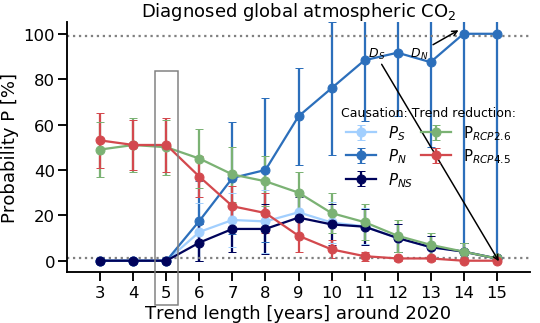

In [141]:
plot_P(P_caus,title='Diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=True,box=True)
plt.savefig(paper_path+'FigureSI_Prob_diag_atm_CO2_rcp45_vs_rcp85_2005')

### Fig S6 RCP 2.6 vs RCP 8.5

In [142]:
# vs 8.5
v='diag_CO2'
# diverge in 2008, 2011 or 2015 or 2020 (still less than 4ppm difference)
P_caus_list=[]
mitigation_start_list = [2008, 2011, 2015, 2020]

for mitigation_start in mitigation_start_list:
    tl=15
    start=mitigation_start-tl+1
    end=mitigation_start+tl
    no_mitigation_scenario='rcp85'
    mitigation_scenario='rcp26'
    print(f'start: {start}, end: {end}, mitigation_start: {mitigation_start}')
    trends = xr_concat_trends(diagnosed_all2,mitigation_date=mitigation_start,start=start,end=end)
    P = bootstrapping(trends, xr_trend_probability, bootstrap=500)
    P_caus = P_to_P_causual(P,no_mitigation_scenarios='rcp85')
    P_caus_list.append(P_caus)

start: 1994, end: 2023, mitigation_start: 2008
Trends 1994 - 2008 2009 - 2023 Trendlength: 15
Trends 1995 - 2008 2009 - 2022 Trendlength: 14
Trends 1996 - 2008 2009 - 2021 Trendlength: 13
Trends 1997 - 2008 2009 - 2020 Trendlength: 12
Trends 1998 - 2008 2009 - 2019 Trendlength: 11
Trends 1999 - 2008 2009 - 2018 Trendlength: 10
Trends 2000 - 2008 2009 - 2017 Trendlength: 9
Trends 2001 - 2008 2009 - 2016 Trendlength: 8
Trends 2002 - 2008 2009 - 2015 Trendlength: 7
Trends 2003 - 2008 2009 - 2014 Trendlength: 6
Trends 2004 - 2008 2009 - 2013 Trendlength: 5


  0%|          | 0/500 [00:00<?, ?it/s]

Trends 2005 - 2008 2009 - 2012 Trendlength: 4
Trends 2006 - 2008 2009 - 2011 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 307.61it/s]


start: 1997, end: 2026, mitigation_start: 2011
Trends 1997 - 2011 2012 - 2026 Trendlength: 15
Trends 1998 - 2011 2012 - 2025 Trendlength: 14
Trends 1999 - 2011 2012 - 2024 Trendlength: 13
Trends 2000 - 2011 2012 - 2023 Trendlength: 12
Trends 2001 - 2011 2012 - 2022 Trendlength: 11
Trends 2002 - 2011 2012 - 2021 Trendlength: 10
Trends 2003 - 2011 2012 - 2020 Trendlength: 9
Trends 2004 - 2011 2012 - 2019 Trendlength: 8
Trends 2005 - 2011 2012 - 2018 Trendlength: 7
Trends 2006 - 2011 2012 - 2017 Trendlength: 6
Trends 2007 - 2011 2012 - 2016 Trendlength: 5


  0%|          | 0/500 [00:00<?, ?it/s]

Trends 2008 - 2011 2012 - 2015 Trendlength: 4
Trends 2009 - 2011 2012 - 2014 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 366.85it/s]


start: 2001, end: 2030, mitigation_start: 2015
Trends 2001 - 2015 2016 - 2030 Trendlength: 15
Trends 2002 - 2015 2016 - 2029 Trendlength: 14
Trends 2003 - 2015 2016 - 2028 Trendlength: 13
Trends 2004 - 2015 2016 - 2027 Trendlength: 12
Trends 2005 - 2015 2016 - 2026 Trendlength: 11
Trends 2006 - 2015 2016 - 2025 Trendlength: 10
Trends 2007 - 2015 2016 - 2024 Trendlength: 9
Trends 2008 - 2015 2016 - 2023 Trendlength: 8
Trends 2009 - 2015 2016 - 2022 Trendlength: 7
Trends 2010 - 2015 2016 - 2021 Trendlength: 6
Trends 2011 - 2015 2016 - 2020 Trendlength: 5
Trends 2012 - 2015 2016 - 2019 Trendlength: 4
Trends 2013 - 2015 2016 - 2018 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 342.75it/s]


start: 2006, end: 2035, mitigation_start: 2020
Trends 2006 - 2020 2021 - 2035 Trendlength: 15
Trends 2007 - 2020 2021 - 2034 Trendlength: 14
Trends 2008 - 2020 2021 - 2033 Trendlength: 13
Trends 2009 - 2020 2021 - 2032 Trendlength: 12
Trends 2010 - 2020 2021 - 2031 Trendlength: 11
Trends 2011 - 2020 2021 - 2030 Trendlength: 10
Trends 2012 - 2020 2021 - 2029 Trendlength: 9
Trends 2013 - 2020 2021 - 2028 Trendlength: 8
Trends 2014 - 2020 2021 - 2027 Trendlength: 7
Trends 2015 - 2020 2021 - 2026 Trendlength: 6
Trends 2016 - 2020 2021 - 2025 Trendlength: 5


  0%|          | 0/500 [00:00<?, ?it/s]

Trends 2017 - 2020 2021 - 2024 Trendlength: 4
Trends 2018 - 2020 2021 - 2023 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 340.25it/s]


              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp85         3
P_N       rcp26_vs_rcp85        12
P_NS      rcp26_vs_rcp85         3
P_mit     rcp26_vs_rcp85         3
P_no_mit  rcp26_vs_rcp85         3 ignore P_RCP45 value
              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp85         3
P_N       rcp26_vs_rcp85         9
P_NS      rcp26_vs_rcp85         3
P_mit     rcp26_vs_rcp85         3
P_no_mit  rcp26_vs_rcp85         3 ignore P_RCP45 value
              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp85         3
P_N       rcp26_vs_rcp85         9
P_NS      rcp26_vs_rcp85         3
P_mit     rcp26_vs_rcp85         3
P_no_mit  rcp26_vs_rcp85         3 ignore P_RCP45 value
              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp85        10
P_N       rcp26_vs_rcp85         9
P_NS      rcp26_vs_rcp85        10
P_mit     rcp26_vs_rcp85   

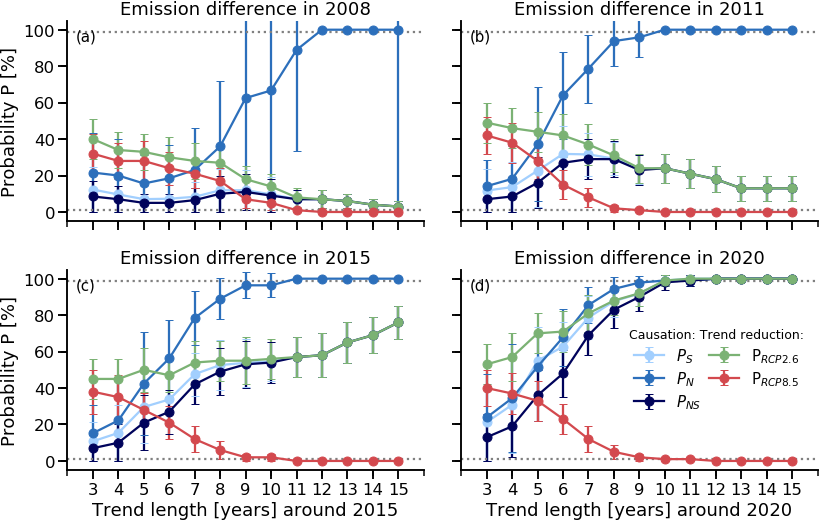

In [143]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(12,8),sharex=True,sharey=True)
for i,axes in enumerate(ax.flatten()):
    plot_P(P_caus_list[i],title='Diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=True,box=False,
       mitigation_start=mitigation_start_list[i],no_mitigation_scenario=no_mitigation_scenario,mitigation_scenario=mitigation_scenario,ax=axes)
    axes.set_title(f'Emission difference in {mitigation_start_list[i]}')
    if i<3:
        axes.get_legend().remove()
set_label(ax,start=0)
fig.subplots_adjust(top=0.9)
#plt.suptitle('Diagnosed global atmospheric CO$_2$')
plt.savefig(f'{paper_path}/FigureSI_Prob_diag_atm_CO2_{mitigation_scenario}_vs_{no_mitigation_scenario}.png',bbox_inches='tight')

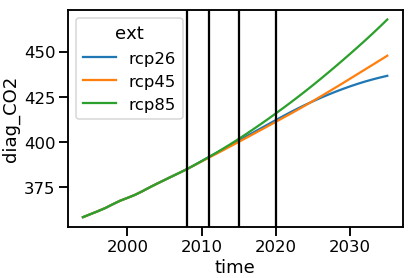

In [103]:
diagnosed_all2.diag_CO2.mean('member').sel(time=slice(1994,2035)).plot(hue='ext')
for i in mitigation_start_list:
    plt.axvline(x=i,c='k')

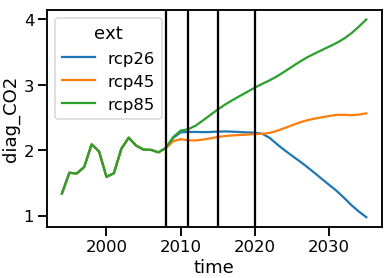

In [104]:
diagnosed_all2.diag_CO2.mean('member').diff('time').sel(time=slice(1994,2035)).plot(hue='ext')
for i in mitigation_start_list:
    plt.axvline(x=i,c='k')

This analysis depends on:
- mitigation strength: which scenarios to compare? PgC difference between scenarios
- timing of mitigation: when mitigation start is defined
- model signal to noise ratio

$P=P(mitigationstrength,mitigationtiming,model)$

### regarding harmonization

In [177]:
v='diag_CO2'
mitigation_date = 2025
start,end=2011,2040
no_mitigation_scenario='rcp45'
mitigation_scenario='rcp26'
trends = xr_concat_trends(diagnosed_harm2,mitigation_date=mitigation_date,end=end,start=start)
P = bootstrapping(trends, xr_trend_probability, bootstrap=500)

P_caus = P_to_P_causual(P,no_mitigation_scenarios='rcp45')

Trends 2011 - 2025 2026 - 2040 Trendlength: 15
Trends 2012 - 2025 2026 - 2039 Trendlength: 14
Trends 2013 - 2025 2026 - 2038 Trendlength: 13
Trends 2014 - 2025 2026 - 2037 Trendlength: 12
Trends 2015 - 2025 2026 - 2036 Trendlength: 11
Trends 2016 - 2025 2026 - 2035 Trendlength: 10
Trends 2017 - 2025 2026 - 2034 Trendlength: 9
Trends 2018 - 2025 2026 - 2033 Trendlength: 8
Trends 2019 - 2025 2026 - 2032 Trendlength: 7
Trends 2020 - 2025 2026 - 2031 Trendlength: 6
Trends 2021 - 2025 2026 - 2030 Trendlength: 5
Trends 2022 - 2025 2026 - 2029 Trendlength: 4


  6%|▌         | 30/500 [00:00<00:01, 296.23it/s]

Trends 2023 - 2025 2026 - 2028 Trendlength: 3


100%|██████████| 500/500 [00:01<00:00, 301.12it/s]


              comparison  diag_CO2
P                                 
P_S       rcp26_vs_rcp45         8
P_N       rcp26_vs_rcp45        15
P_NS      rcp26_vs_rcp45        15
P_mit     rcp26_vs_rcp45         8
P_no_mit  rcp26_vs_rcp45         3 ignore P_RCP45 value


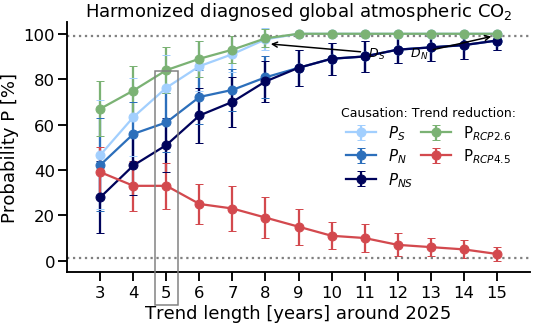

In [178]:
plot_P(P_caus,title='Harmonized diagnosed global atmospheric CO$_2$',v='diag_CO2',causation=True,box=True,
       mitigation_start=mitigation_date,no_mitigation_scenario=no_mitigation_scenario,mitigation_scenario=mitigation_scenario)
plt.savefig(f'{paper_path}/FigureSI_Prob_harm_diag_atm_CO2_{mitigation_scenario}_vs_{no_mitigation_scenario}.eps',bbox_inches='tight')

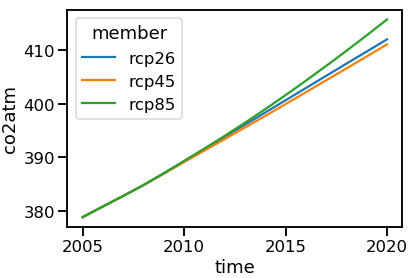

In [339]:
co2atm_forcing.sel(time=slice(2005,2020))['co2atm'].plot.line(hue='member')

## Fig S7

In [444]:
co2_growth_rate = pd.read_csv('ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_gr_mlo.txt',header=59, sep='   ')

In [445]:
co2_growth_rate.columns = ['Year', '1','Ann inc', '2', 'unc']

In [446]:
co2_growth_rate=co2_growth_rate[['Year','Ann inc', 'unc']].set_index('Year')

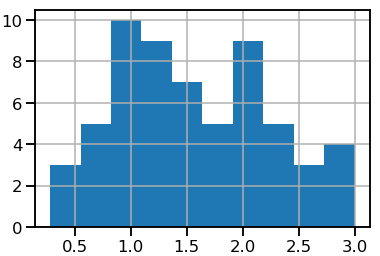

In [447]:
co2_growth_rate['Ann inc'].hist()

In [448]:
co2_growth_rate['Ann inc'].describe()

count    60.000000
mean      1.577500
std       0.672296
min       0.280000
25%       1.037500
50%       1.525000
75%       2.040000
max       3.000000
Name: Ann inc, dtype: float64

In [451]:
model = (cf_internal_variability['co2_flux'].sel(time=slice(1958,2018)).sel(member='rcp45',drop=True).cumsum('time')/2.13
         +co2atm_forcing.sel(time=slice(1958,2018)).isel(member=0,drop=True)).diff('time').to_dataframe()

In [452]:
model.describe().round(2)

,co2atm
count,6000.00
mean,1.54
std,0.86
min,-1.34
25%,0.94
50%,1.54
75%,2.12
max,5.03


In [453]:
comparison = pd.merge(model.describe(),co2_growth_rate['Ann inc'].describe(),left_index=True,right_index=True).round(2)
comparison.columns = ['modelled','observed']
comparison

,modelled,observed
count,6000.00,60.00
mean,1.54,1.58
std,0.86,0.67
min,-1.34,0.28
25%,0.94,1.04
50%,1.54,1.52
75%,2.12,2.04
max,5.03,3.00


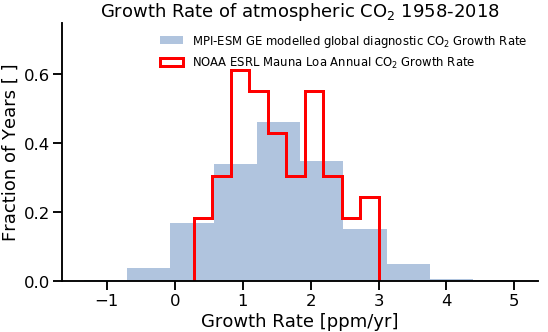

In [467]:
alpha=1
density=True
fig,ax=plt.subplots(figsize=(8,5))
model.hist(ax=ax,density=True, color='lightsteelblue',label='MPI-ESM GE modelled global diagnostic CO$_2$ Growth Rate',alpha=alpha)
co2_growth_rate['Ann inc'].hist(color='red',lw=3,histtype='step',ax=ax,density=True,label='NOAA ESRL Mauna Loa Annual CO$_2$ Growth Rate',alpha=alpha)
plt.legend(frameon=False, fontsize='small')
plt.ylabel('Fraction of Years [ ]')
plt.xlabel('Growth Rate [ppm/yr]')
plt.title('Growth Rate of atmospheric CO$_2$ 1958-2018')
plt.tight_layout()
plt.ylim([0,.75])
sb.despine()
ax.grid(False)
plt.savefig(paper_path+'FigureSI_Growth_Rate_distribution')

## compatible emissions

In [67]:
ce_path=f'{data_path}compatible_emissions.nc'

# calculated by https://esmtools.readthedocs.io/en/stable/api/esmtools.carbon.calculate_compatible_emissions.html
ce=xr.open_dataset(ce_path)['compatible_emissions']

In [49]:
colors = ["faded green", "faded red", "orange"]
cmap=sb.xkcd_palette(colors)

sb.set_palette(cmap)

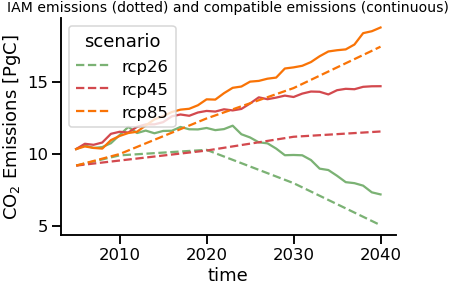

In [64]:
ce.sel(time=slice(2005,2040)).mean('initialization').rename({'member':'scenario'}).plot(hue='scenario')#,ax=ax[0])
emissions['total_anth'].drop_sel(scenario='GCB').plot(hue='scenario',ls='--')#,ax=ax[1])
plt.ylabel('CO$_2$ Emissions [PgC]')
plt.title('IAM emissions (dotted) and compatible emissions (continuous)',fontsize=14)
sb.despine()
plt.savefig(paper_path+'FigureSI_emissions_compatible_vs_IAM.png')